In [1]:
# import the necessary packages
# Base packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import random

# Pyleoclim for integration
import pyleoclim as pyleo

# The magic 
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Function creation

In [3]:
def detect_outliers_kmeans(ys, nbr_clusters = None, max_cluster = 10, threshold=3, LOF=False, kmeans_kwargs=None):
    """
    Outlier detection using the unsupervised alogrithm kmeans. The algorithm runs through various number of clusters and optimizes based on the silhouette score.
    
    KMeans implementation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. For additional details, see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

    Parameters
    ----------
    ys : numpy.array
        The y-values for the timeseries data
    nbr_clusters : int or list, optional
        A user number of clusters to considered. The default is None.
    max_cluster : int, optional
        The maximum number of clusters to consider in the optimization based on the Silhouette Score. The default is 10.
    threshold : int, optional
        The algorithm uses the euclidean distance for each point in the cluster to identify the outliers. This parameter sets the threshold on the euclidean distance to define an outlier. The default is 3.
    LOF: bool, optional
        By default, detect_outliers_kmeans uses euclidean distance for outlier detection. Set LOF to True to use LocalOutlierFactor for outlier detection.
    kmeans_kwargs : dict, optional
        Other parameters for the kmeans function. See: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for details. The default is None.

    Returns
    -------
    indices : list
        list of indices that are considered outliers.
    res : pandas.DataFrame
        Results of the clustering analysis. Contains information about number of clusters, the silhouette score, the indices of the outliers for each combination, and the cluster assignment for each point. 


    """
    
    
    kmeans_kwargs = {} if kmeans_kwargs is None else kmeans_kwargs.copy()
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    # run with either one cluster number of several
    if nbr_clusters is not None:
        if type(nbr_clusters) == list:
            range_n_clusters = nbr_clusters
        else:
            range_n_clusters = [nbr_clusters]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    clusters = []
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1), **kmeans_kwargs)
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        if LOF:
            model = LocalOutlierFactor(n_neighbors=int(ys.shape[0]*0.95), contamination='auto')
            pred = model.fit_predict(ys.reshape(-1,1))
            idx_out.append(np.where(pred==-1))
        else:
            distance=np.sqrt((ys-center)**2)
            idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
        clusters.append(kmeans.labels_)
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out,'clusters':clusters})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

### Noisy dataset

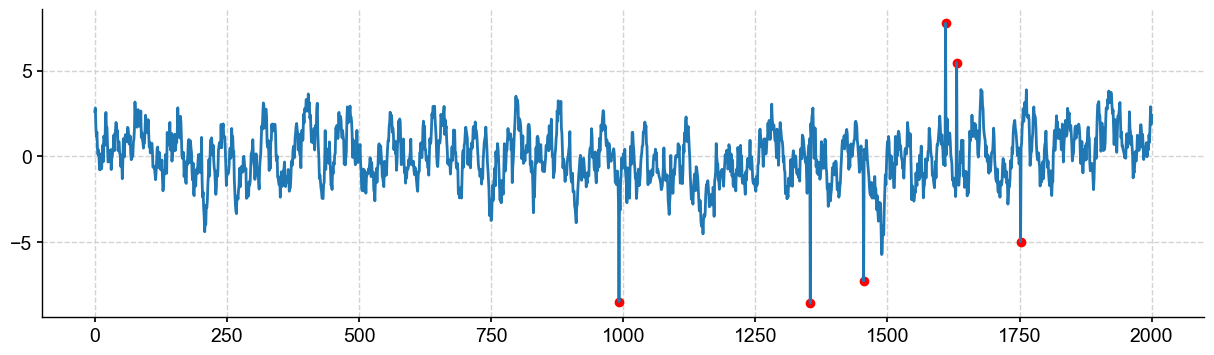

In [4]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise
t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

# set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

In [5]:
pred1, res1 = detect_outliers_kmeans(signal_out)
res1.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.556417,"[992, 1354, 1455, 1610]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, ..."
1,3,0.524745,"[992, 1354, 1455, 1610]","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4,0.515277,"[992, 1354, 1455, 1610]","[2, 2, 2, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, ..."
3,5,0.520510,"[992, 1354, 1610]","[4, 4, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, ..."
4,6,0.527439,"[1354, 1610]","[1, 1, 3, 3, 3, 2, 2, 2, 2, 5, 5, 2, 2, 5, 2, ..."


In [6]:
pred2, res2 = detect_outliers_kmeans(signal_out, LOF=True)
res2.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.556404,"([992, 1354, 1455, 1489, 1490, 1610, 1631],)","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, ..."
1,3,0.525629,"([992, 1354, 1455, 1489, 1490, 1610, 1631],)","[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,4,0.516542,"([992, 1354, 1455, 1489, 1490, 1610, 1631],)","[2, 2, 2, 0, 2, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, ..."
3,5,0.521398,"([992, 1354, 1455, 1489, 1490, 1610, 1631],)","[2, 2, 4, 4, 4, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, ..."
4,6,0.526549,"([992, 1354, 1455, 1489, 1490, 1610, 1631],)","[3, 3, 0, 0, 0, 2, 2, 2, 2, 5, 5, 2, 2, 5, 2, ..."


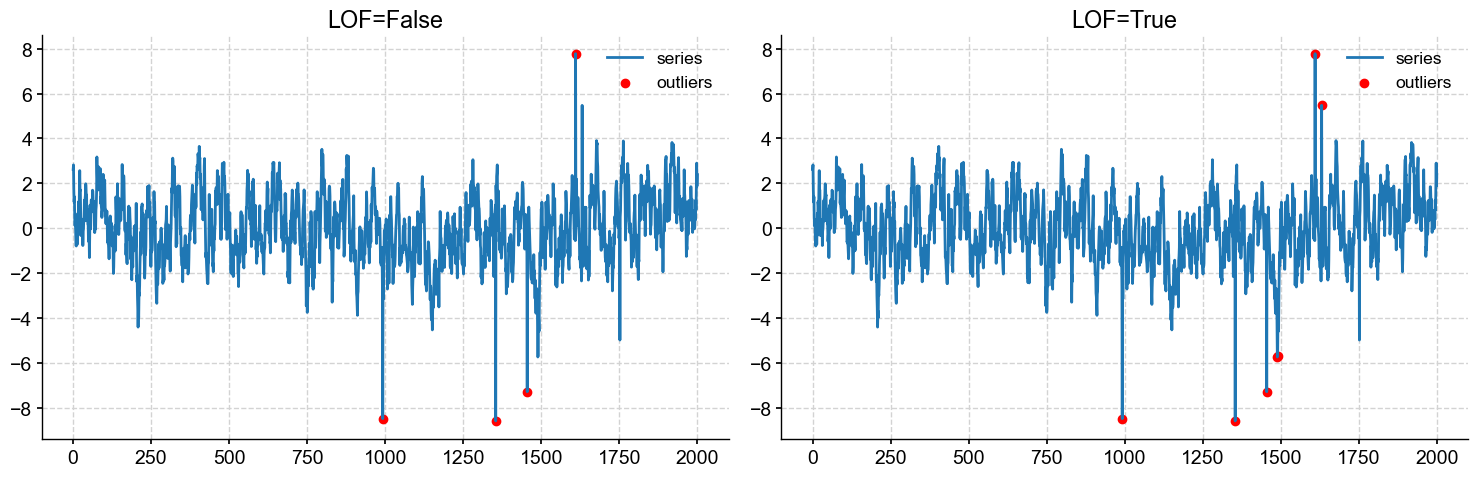

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, p in enumerate([pred1, pred2]):
    row, col = divmod(i, 2)
    #ax = axes[row, col]
    ax = axes[col]
    
    xs_out=time[p]
    ys_out=signal_out[p]
    
    ax.plot(time,signal_out,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    if i == 0:
        ax.set_title('LOF=False')
    else:
        ax.set_title('LOF=True')

plt.tight_layout()
plt.show()

#### If n_neighbors = total number of sample points ( = 2001)

In [8]:
def test(ys, nbr_clusters = None, max_cluster = 10, threshold=3, LOF=False, kmeans_kwargs=None):
    kmeans_kwargs = {} if kmeans_kwargs is None else kmeans_kwargs.copy()
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    # run with either one cluster number of several
    if nbr_clusters is not None:
        if type(nbr_clusters) == list:
            range_n_clusters = nbr_clusters
        else:
            range_n_clusters = [nbr_clusters]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    clusters = []
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1), **kmeans_kwargs)
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        if LOF:
            model = LocalOutlierFactor(n_neighbors=int(ys.shape[0]), contamination='auto')
            pred = model.fit_predict(ys.reshape(-1,1))
            idx_out.append(np.where(pred==-1))
        else:
            distance=np.sqrt((ys-center)**2)
            idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
        clusters.append(kmeans.labels_)
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out,'clusters':clusters})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

In [9]:
p, r = test(signal_out, LOF=True)
r.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.556412,"([],)","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, ..."
1,3,0.525439,"([],)","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4,0.517046,"([],)","[0, 0, 0, 2, 0, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, ..."
3,5,0.520384,"([],)","[4, 4, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, ..."
4,6,0.526520,"([],)","[5, 5, 1, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, ..."


### Paleoclimate dataset
#### MD98-2181

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: MD982181.Khider.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Finished read: 1 record
extracting paleoData...
extracting: MD982181.Khider.2014
Created time series: 31 entries


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [cal yr BP]', ylabel='sst [degrees Celcius]'>)

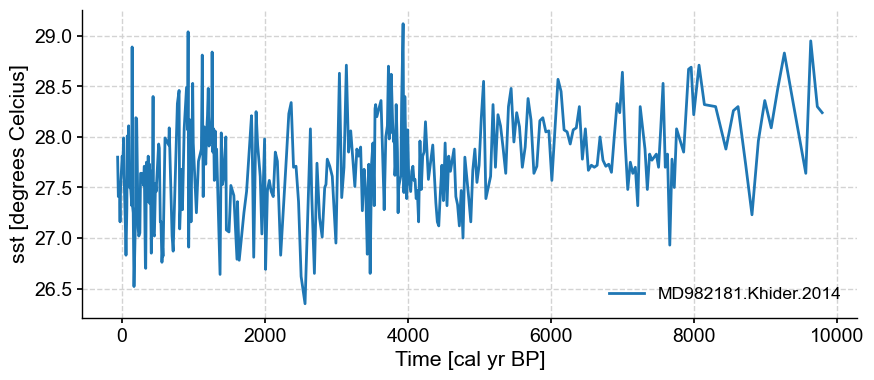

In [10]:
D=pyleo.Lipd('MD982181.Khider.2014.lpd')
ts=D.to_LipdSeries(number=14)
ts.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [cal yr BP]', ylabel='sst [degrees Celcius]'>)

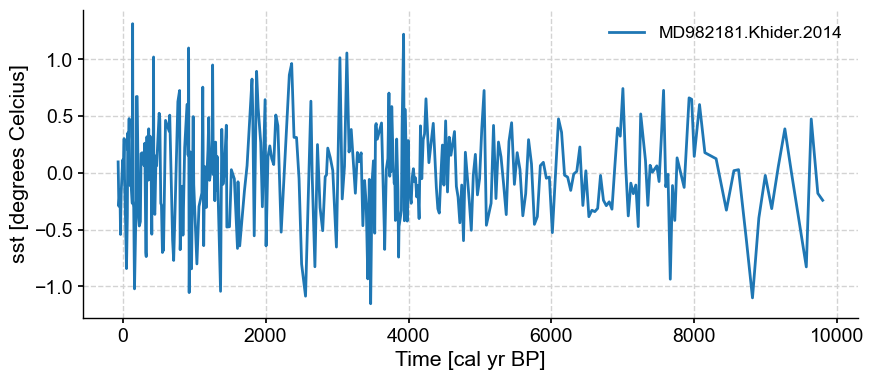

In [11]:
ts_detrended=ts.detrend(n=2)
ts_detrended.plot()

In [12]:
pred1, res1 = detect_outliers_kmeans(ts_detrended.value)
res1.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.522023,[],"[1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ..."
1,3,0.537813,[],"[2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0, 1, 2, ..."
2,4,0.532683,[],"[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 3, 1, 2, 0, ..."
3,5,0.555560,[],"[2, 0, 2, 0, 0, 2, 2, 2, 4, 2, 0, 3, 0, 4, 4, ..."
4,6,0.542722,[],"[2, 1, 3, 1, 1, 3, 2, 3, 2, 3, 1, 4, 1, 2, 2, ..."


In [13]:
pred2, res2 = detect_outliers_kmeans(ts_detrended.value, LOF=True)
res2.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.521918,"([],)","[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
1,3,0.537748,"([],)","[0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, ..."
2,4,0.532683,"([],)","[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 3, 0, 2, 1, ..."
3,5,0.556463,"([],)","[0, 4, 0, 4, 4, 0, 0, 0, 3, 0, 4, 2, 4, 3, 3, ..."
4,6,0.542459,"([],)","[4, 1, 0, 1, 1, 0, 4, 0, 4, 0, 1, 3, 1, 4, 4, ..."


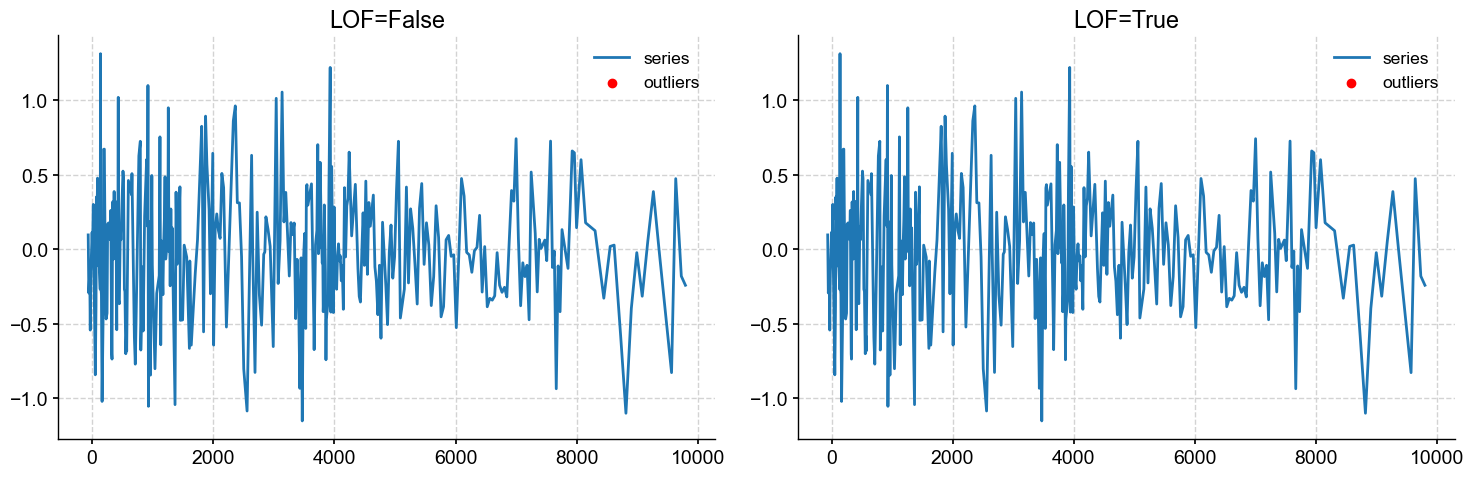

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, p in enumerate([pred1, pred2]):
    row, col = divmod(i, 2)
    #ax = axes[row, col]
    ax = axes[col]
    
    indices=p
    if indices:
        xs_out=ts_detrended.time[indices]
        ys_out=ts_detrended.value[indices]
    else:
        xs_out = ys_out = np.array(None)
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    if i == 0:
        ax.set_title('LOF=False')
    else:
        ax.set_title('LOF=True')

plt.tight_layout()
plt.show()

#### GISP2 d18O

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

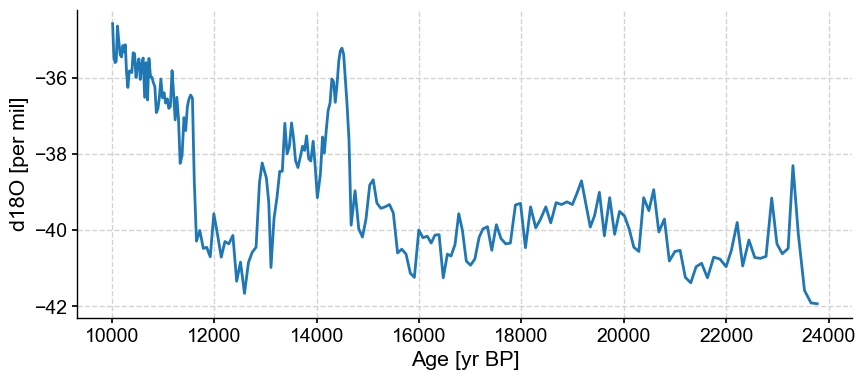

In [15]:
df = pd.read_csv('GISP2_Deglacial.csv')
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='d18O',
                time_unit='yr BP', value_unit='per mil')
ts.plot()

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

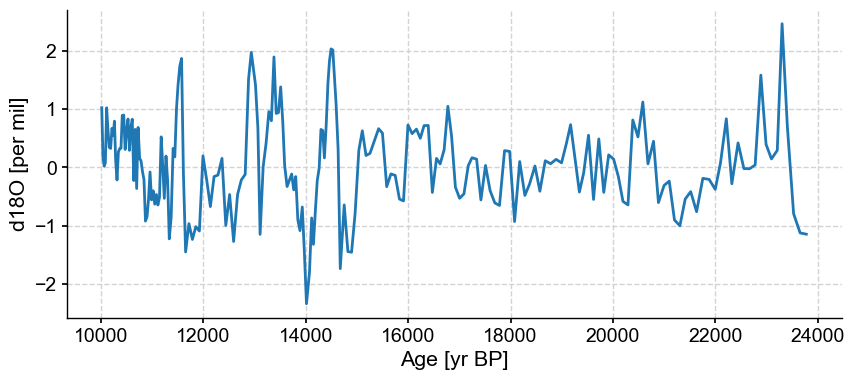

In [16]:
ts_detrended=ts.detrend(n=2)
ts_detrended.plot()

In [17]:
pred1, res1 = detect_outliers_kmeans(ts_detrended.value)
res1.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.524271,[],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,3,0.518039,[],"[1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, ..."
2,4,0.527952,[],"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ..."
3,5,0.576505,[],"[3, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 4, 0, 4, 4, ..."
4,6,0.559769,[],"[4, 0, 0, 0, 4, 4, 0, 0, 4, 4, 4, 0, 5, 0, 0, ..."


In [18]:
pred2, res2 = detect_outliers_kmeans(ts_detrended.value, LOF=True)
res2.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.531401,"([],)","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,3,0.518039,"([],)","[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
2,4,0.529795,"([],)","[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ..."
3,5,0.576505,"([],)","[4, 2, 2, 2, 4, 4, 2, 2, 4, 4, 4, 2, 3, 2, 2, ..."
4,6,0.559769,"([],)","[2, 5, 5, 5, 2, 2, 5, 5, 2, 2, 2, 5, 0, 5, 5, ..."


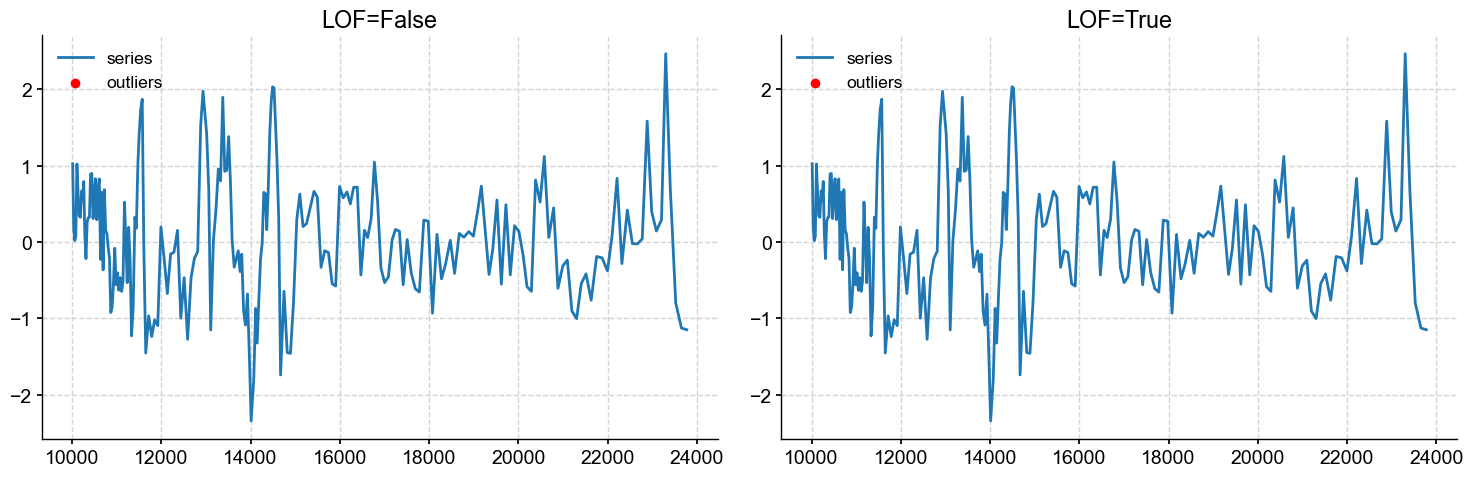

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, p in enumerate([pred1, pred2]):
    row, col = divmod(i, 2)
    #ax = axes[row, col]
    ax = axes[col]
    
    indices=p
    if indices:
        xs_out=ts_detrended.time[indices]
        ys_out=ts_detrended.value[indices]
    else:
        xs_out = ys_out = np.array(None)
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    if i == 0:
        ax.set_title('LOF=False')
    else:
        ax.set_title('LOF=True')

plt.tight_layout()
plt.show()

#### LR04

Time axis values sorted in ascending order


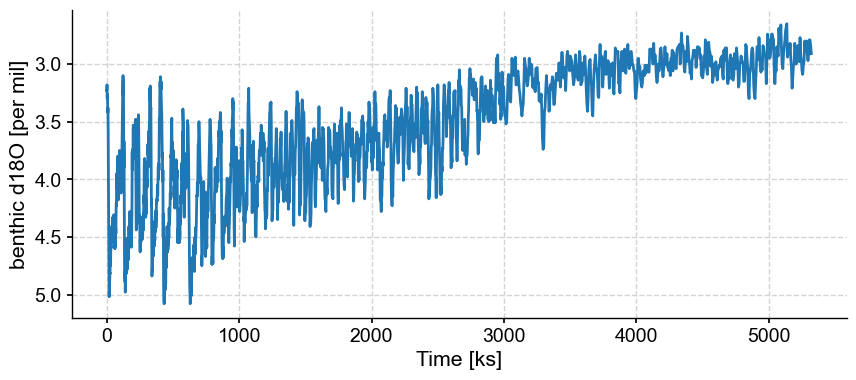

In [20]:
df = pd.read_csv('LR04.csv',skiprows=4)
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='benthic d18O',
                time_unit='ks', value_unit='per mil')
fig,ax = ts.plot()
ax.invert_yaxis()

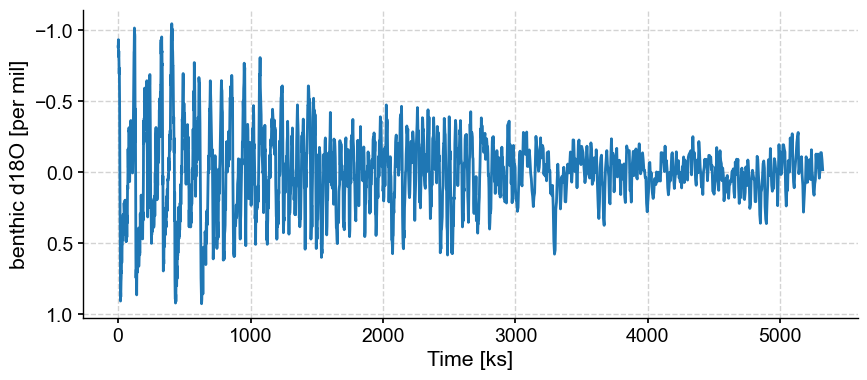

In [21]:
ts_detrended = ts.detrend()
fig,ax = ts_detrended.plot()
ax.invert_yaxis()

In [22]:
pred1, res1 = detect_outliers_kmeans(ts_detrended.value)
res1.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.525149,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,3,0.542776,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, ..."
2,4,0.527340,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, ..."
3,5,0.526137,[],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 0, 3, ..."
4,6,0.524027,[],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 1, 2, ..."


In [23]:
pred2, res2 = detect_outliers_kmeans(ts_detrended.value, LOF=True)
res2.head()

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.525149,"([],)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,3,0.544532,"([],)","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, ..."
2,4,0.528353,"([],)","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, ..."
3,5,0.526583,"([],)","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 0, ..."
4,6,0.523599,"([],)","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 4, ..."


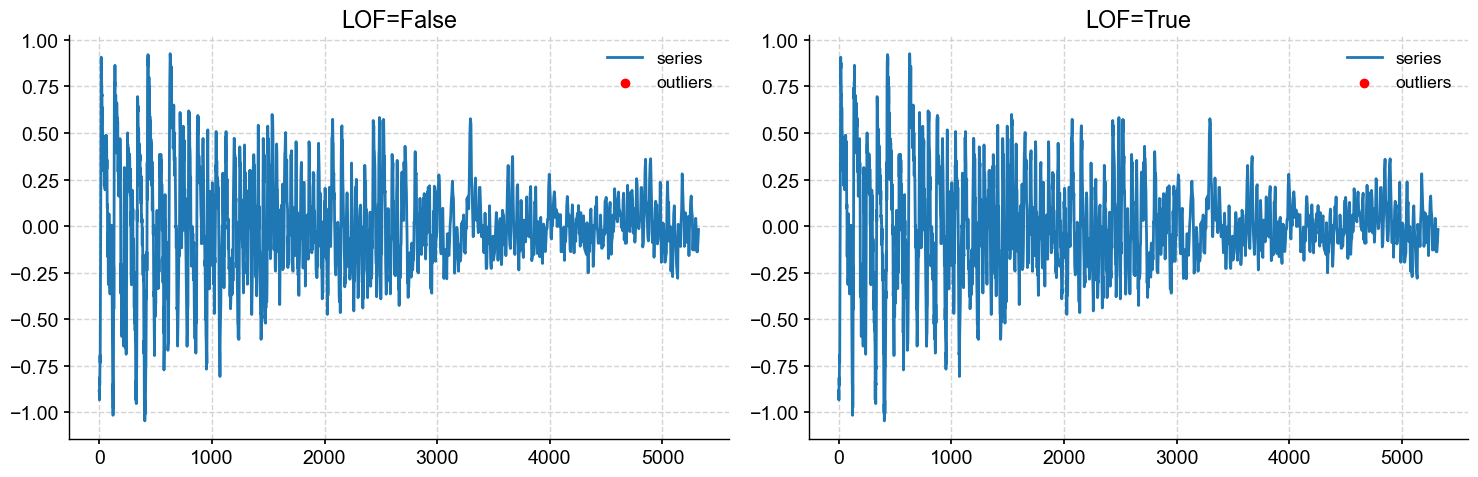

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, p in enumerate([pred1, pred2]):
    row, col = divmod(i, 2)
    #ax = axes[row, col]
    ax = axes[col]
    
    indices=p
    if indices:
        xs_out=ts_detrended.time[indices]
        ys_out=ts_detrended.value[indices]
    else:
        xs_out = ys_out = np.array(None)
    
    ax.plot(ts_detrended.time, ts_detrended.value,label='series')
    ax.scatter(xs_out,ys_out,color='r',label='outliers')
    ax.legend()
    if i == 0:
        ax.set_title('LOF=False')
    else:
        ax.set_title('LOF=True')

plt.tight_layout()
plt.show()